In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, HuberRegressor, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score


In [8]:

# Set random seed and display settings
np.random.seed(42)
plt.rcParams['figure.figsize'] = (12, 6)

# Load dataset
file_path = os.path.join(os.getcwd(), "data", "dynamic_pricing.csv")
data = pd.read_csv(file_path)

# Initial data overview
print("Dataset shape:", data.shape)
print(data.head())

# Preprocess categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_columns.tolist())

# One-hot encode categorical variables
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

Dataset shape: (1000, 10)
   Number_of_Riders  Number_of_Drivers Location_Category  \
0                90                 45             Urban   
1                58                 39          Suburban   
2                42                 31             Rural   
3                89                 28             Rural   
4                78                 22             Rural   

  Customer_Loyalty_Status  Number_of_Past_Rides  Average_Ratings  \
0                  Silver                    13             4.47   
1                  Silver                    72             4.06   
2                  Silver                     0             3.99   
3                 Regular                    67             4.31   
4                 Regular                    74             3.77   

  Time_of_Booking Vehicle_Type  Expected_Ride_Duration  \
0           Night      Premium                      90   
1         Evening      Economy                      43   
2       Afternoon      Premium

In [9]:
data

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride,Location_Category_Suburban,Location_Category_Urban,Customer_Loyalty_Status_Regular,Customer_Loyalty_Status_Silver,Time_of_Booking_Evening,Time_of_Booking_Morning,Time_of_Booking_Night,Vehicle_Type_Premium
0,90,45,13,4.47,90,284.257273,False,True,False,True,False,False,True,True
1,58,39,72,4.06,43,173.874753,True,False,False,True,True,False,False,False
2,42,31,0,3.99,76,329.795469,False,False,False,True,False,False,False,True
3,89,28,67,4.31,134,470.201232,False,False,True,False,False,False,False,True
4,78,22,74,3.77,149,579.681422,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,33,23,24,4.21,11,91.389526,False,True,False,False,False,True,False,True
996,84,29,92,4.55,94,424.155987,False,True,True,False,False,True,False,True
997,44,6,80,4.13,40,157.364830,True,False,False,False,False,False,True,True
998,53,27,78,3.63,58,279.095048,True,False,True,False,False,False,True,True


In [10]:
new_categorical_columns = [col for col in data.columns if data[col].dtype == 'bool']

print("Categorical columns to convert:", new_categorical_columns)
# Convert only the categorical columns (boolean) to integers
data[new_categorical_columns] = data[new_categorical_columns].astype(int)
# Verify data types of the columns
print(data.dtypes)

# Ensure values are 0 and 1
for col in new_categorical_columns:
    print(f"{col}: {data[col].unique()}")

data = data.sample(frac=1)

Categorical columns to convert: ['Location_Category_Suburban', 'Location_Category_Urban', 'Customer_Loyalty_Status_Regular', 'Customer_Loyalty_Status_Silver', 'Time_of_Booking_Evening', 'Time_of_Booking_Morning', 'Time_of_Booking_Night', 'Vehicle_Type_Premium']
Number_of_Riders                     int64
Number_of_Drivers                    int64
Number_of_Past_Rides                 int64
Average_Ratings                    float64
Expected_Ride_Duration               int64
Historical_Cost_of_Ride            float64
Location_Category_Suburban           int64
Location_Category_Urban              int64
Customer_Loyalty_Status_Regular      int64
Customer_Loyalty_Status_Silver       int64
Time_of_Booking_Evening              int64
Time_of_Booking_Morning              int64
Time_of_Booking_Night                int64
Vehicle_Type_Premium                 int64
dtype: object
Location_Category_Suburban: [0 1]
Location_Category_Urban: [1 0]
Customer_Loyalty_Status_Regular: [0 1]
Customer_Loyalty_S

In [15]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, HuberRegressor, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# Prepare data
X = data.drop('Historical_Cost_of_Ride', axis=1)
y = data['Historical_Cost_of_Ride']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models and parameters
models_and_params = {
    "LinearRegression": (LinearRegression(fit_intercept=False), {}),
    "HuberRegressor": (HuberRegressor(fit_intercept=False), {"alpha": np.logspace(-2, 1, 5), "epsilon": [1.35, 1.5, 1.75]}),
    "Lasso": (Lasso(fit_intercept=False), {"alpha": np.logspace(-3, 0, 4)}),
    "Ridge": (Ridge(fit_intercept=False), {"alpha": np.logspace(-2, 1, 5), "solver": ["auto", "svd", "cholesky"]}),
    "ElasticNet": (ElasticNet(fit_intercept=False), {"alpha": np.logspace(-3, 0, 4), "l1_ratio": [0.1, 0.5, 0.9]}),
}


# Scale the features using Min-Max Scaler
scaler = MinMaxScaler()
X_train_scaled = X_train#scaler.fit_transform(X_train)
X_test_scaled = X_test# scaler.transform(X_test)
# Re-evaluate models with scaled data and include MAE for test data
scaled_results = []
for name, (model, params) in models_and_params.items():
    try:
        grid_search = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)

        best_model = grid_search.best_estimator_
        best_score = -grid_search.best_score_  # Convert to positive
        y_test_pred = best_model.predict(X_test_scaled)

        # Calculate metrics
        test_mse = mean_squared_error(y_test, y_test_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)  # Test MAE
        test_r2 = r2_score(y_test, y_test_pred)

        # Extract CV MAE for all hyperparameter combinations
        cv_mae_all = -grid_search.cv_results_["mean_test_score"]  # Convert to positive MAE
        param_combinations = grid_search.cv_results_["params"]

        scaled_results.append({
            "Model": name,
            "Mean_CV_MAE": best_score,
            "Test_MAE": test_mae,
            "Test_MSE": test_mse,
            "Test_R2": test_r2,
            "Best_Params": grid_search.best_params_,
            "CV_MAE_All": list(zip(param_combinations, cv_mae_all)),  # Include all CV MAEs with hyperparameters
            "Best_Model": best_model
        })
    except Exception as e:
        print(f"Model {name} failed with error: {e}")

# Convert scaled results to DataFrame
scaled_results_df = pd.DataFrame(scaled_results)
scaled_results_df = scaled_results_df.sort_values(by="Test_MAE")

# Display scaled results
print(scaled_results_df[["Model", "Mean_CV_MAE", "Test_MAE", "Test_MSE", "Test_R2"]])

# Example: Access all CV MAE for the top model
top_model_cv_mae = scaled_results_df.iloc[0]["CV_MAE_All"]
print(f"\nAll CV MAE for top model ({scaled_results_df.iloc[0]['Model']}):")
for params, cv_mae in top_model_cv_mae:
    print(f"Params: {params}, CV MAE: {cv_mae}")

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Inc

              Model  Mean_CV_MAE   Test_MAE     Test_MSE   Test_R2
2             Lasso    51.889670  50.319286  4242.067139  0.885407
1    HuberRegressor    52.122650  50.748019  4274.583298  0.884528
4        ElasticNet    52.175695  50.768140  4279.824363  0.884387
3             Ridge    52.264829  50.805516  4264.353372  0.884805
0  LinearRegression    52.363491  50.849894  4263.014365  0.884841

All CV MAE for top model (Lasso):
Params: {'alpha': np.float64(0.001)}, CV MAE: 52.36236931503413
Params: {'alpha': np.float64(0.01)}, CV MAE: 52.35227386558667
Params: {'alpha': np.float64(0.1)}, CV MAE: 52.26151813170592
Params: {'alpha': np.float64(1.0)}, CV MAE: 51.889670261850505


In [19]:
# Extract the top-performing model
top_model_row = scaled_results_df.iloc[0]
top_model_name = top_model_row["Model"]
top_model = top_model_row["Best_Model"]

# Check if the model is linear (e.g., LinearRegression, Lasso, Ridge, ElasticNet, HuberRegressor)
if hasattr(top_model, "coef_") and hasattr(top_model, "intercept_"):
    coefficients = top_model.coef_  # Coefficients of the features
    intercept = top_model.intercept_  # Intercept of the equation

    # Get feature names from the dataset
    feature_names = X_train.columns

    # Construct the equation, excluding terms with zero coefficients
    terms = [f"{coef:.4f} * {feature}" for coef, feature in zip(coefficients, feature_names) if coef != 0]
    equation = "y = " + " + ".join(terms) + f" + {intercept:.4f}"

    print(f"Best Model: {top_model_name}")
    print("Best Equation:")
    print(equation)

else:
    print(f"The best model '{top_model_name}' does not provide coefficients. It may not be a linear model.")


Best Model: Lasso
Best Equation:
y = -0.1398 * Number_of_Riders + 0.4665 * Number_of_Drivers + -0.0033 * Number_of_Past_Rides + 3.4973 * Expected_Ride_Duration + -2.4212 * Time_of_Booking_Evening + 39.5754 * Vehicle_Type_Premium + 0.0000


In [20]:
# Extract the top-performing model
top_model_row = scaled_results_df.iloc[0]
top_model_name = top_model_row["Model"]
top_model = top_model_row["Best_Model"]
top_model_params = top_model_row["Best_Params"]

# Print the best model details
print(f"Best Model: {top_model_name}")
print(f"Best Parameters: {top_model_params}")
# Make predictions
predictions = top_model.predict(X_test_scaled)

print("\nPredictions on new data:")
print(predictions)

Best Model: Lasso
Best Parameters: {'alpha': np.float64(1.0)}

Predictions on new data:
[467.64349821 578.85025457 374.61981053 527.53818709 298.21046388
 269.31312931 117.15454591 529.24948461 223.24247781 464.57540623
 244.19935251 159.41991289 149.60611438 655.67757239 498.20239422
 369.8074159   36.42447285 534.17849909  50.45123909 585.53476263
 640.94926738 106.59291304 379.2181161  617.3533679  357.75732539
 587.57538451 273.05936636 238.02652748 144.49672055  85.19259618
 505.27516439 273.78387521 174.62619314 678.54857861 118.36214764
 637.42244037 103.68528573 582.29615314 362.27073719 566.2421532
 187.60116348 554.26684433 386.1391204  113.7083594  615.36210974
 463.70906339 508.37512842  48.31546675  75.01572977  84.98739918
 438.84398708 665.71336597 429.59775084 464.34799476 379.42533701
 345.67306771 628.93491128 365.48574401 132.11089217 585.27627232
 558.6019645  196.74356961 333.01932515 318.81671456 519.59203542
 252.35131582 545.35851453 207.26738702 420.72240557 30

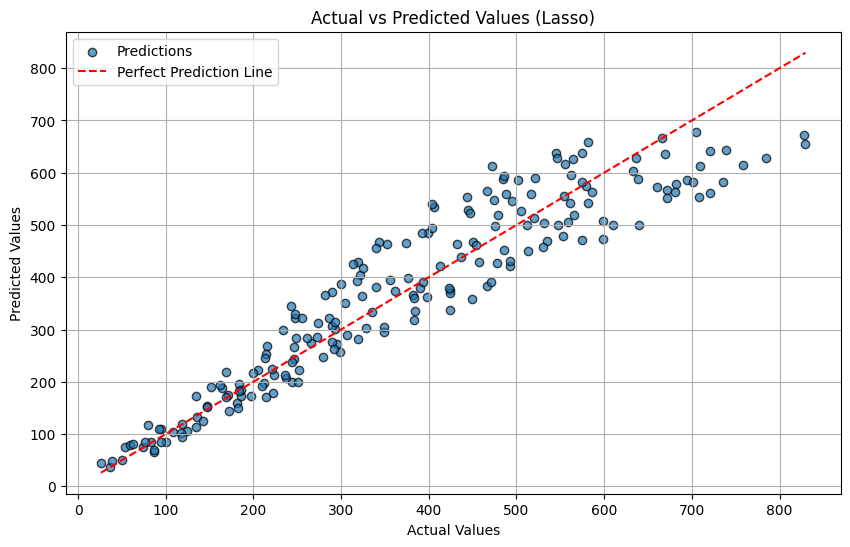

In [21]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.7, edgecolor='k', label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label="Perfect Prediction Line")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs Predicted Values ({top_model_name})")
plt.legend()
plt.grid(True)
plt.show()